# Задание

Обозначения:

p - глубина истории, сколько измерений назад учитываем в моделях

h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

***1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .***

In [ ]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
scl =StandardScaler()
scly =StandardScaler()


import os

%matplotlib inline

sns.set(rc={'figure.figsize':(16,9)})

In [51]:
# Всякие рукописные функции
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def split_data_b( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [25]:
# считаем данные
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [29]:
d_data=data.resample('D').mean()

In [40]:
data_exp_1 = exponential_smoothing(d_data['PJME_MW']  , 0.05)

In [44]:
df= pd.DataFrame(data_exp_1,index=d_data.index)
df.head()
 # добавили историю на глубину 3 измерения от текущего (р=3)
df['t'] = 0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t1']=0
df.iloc[2:,2]=df.iloc[:-2,0].values
df['t2']=0
df.iloc[3:,3]=df.iloc[:-3,0].values
df.fillna(0)
# добавили сглаживание (3 вида - просто для коллекции)
df['exp_0_01'] = exponential_smoothing(df[0], 0.01)
df['exp_0_03'] = exponential_smoothing(df[0], 0.03)
df['exp_0_08'] = exponential_smoothing(df[0], 0.08)
# добавим разности - 1-й порядок
df['diff1'] = 0
df['diff1'].iloc[1:] = df.iloc[:-1,0]-df.iloc[1:,0]


df.head()

,0,t,t1,t2,exp_0_01,exp_0_03,exp_0_08,diff1
Date,,,,,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000,31080.739130,31080.739130,31080.739130,0.0
2002-01-02,31239.779257,31080.739130,0.000000,0.000000,31082.329532,31085.510334,31093.462341,0.0
2002-01-03,31403.384044,31239.779257,31080.739130,0.000000,31085.540077,31095.046546,31118.256077,0.0
2002-01-04,31518.987759,31403.384044,31239.779257,31080.739130,31089.874554,31107.764782,31150.314611,0.0
2002-01-05,31463.294621,31518.987759,31403.384044,31239.779257,31093.608754,31118.430677,31175.353012,0.0


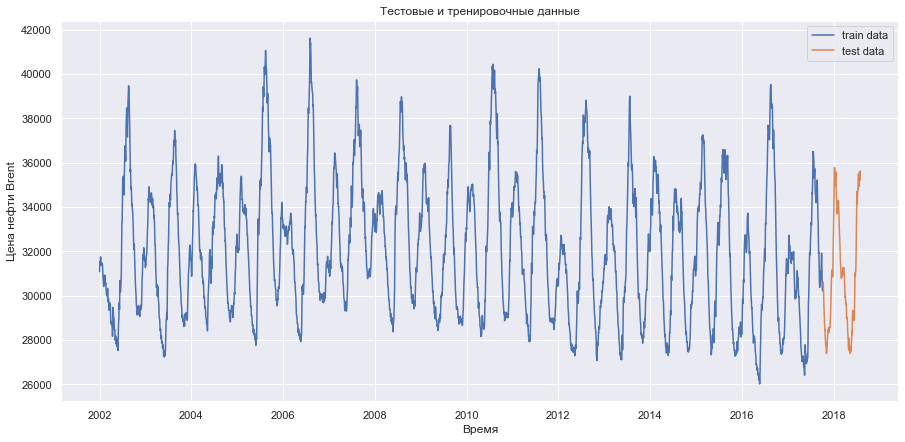

In [48]:
train_b, test_b = split_data_b( df, '10-10-2017')

X_train_b = train_b.iloc[:-1,:]
y_train_b = train_b[df.columns[0]].values[1:]
X_test_b = test_b.iloc[:-1,:]
y_test_b = test_b[df.columns[0]].values[1:]


plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('PJME_MW')
plt.plot(train_b.index.get_level_values('Date'),train_b[df.columns[0]], label='train data' )
plt.plot(test_b.index.get_level_values('Date'),test_b[df.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

***2. Оцените ошибку модели из п.1 .***

Прогноз с глубиной 1

In [50]:

model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

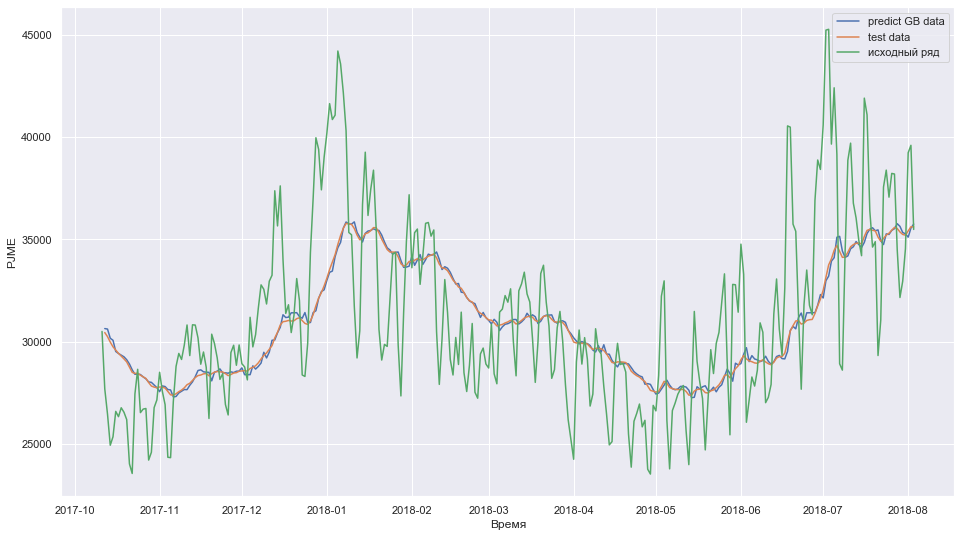

ошибка градиентного бустинга :   0.4536011762843374 %


In [53]:
plt.xlabel('Время')
plt.ylabel('PJME')
plt.plot(test_b.index[1:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[1:],y_test_b, label='test data')
plt.plot(d_data.loc['2017-10-11':].index, d_data.loc['2017-10-11':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

Прогноз с глубиной 10

In [55]:
h=10
X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df.columns[0]].values[h:]

model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

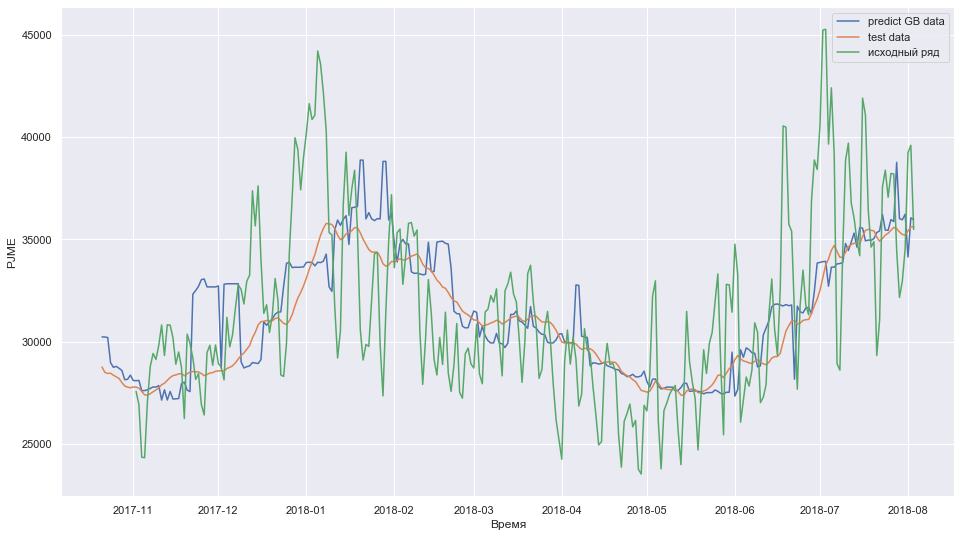

ошибка градиентного бустинга :   3.2711580175524215 %


In [57]:
plt.xlabel('Время')
plt.ylabel('PJME')
plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b, label='test data')
plt.plot(d_data.loc['2017-11-02':].index, d_data.loc['2017-11-02':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

***3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.***

Как можно видеть на графиках и ошибке. Модель с прогнозирования глубиной 1 более точная, чем  модель прогнозирования с глубиной 10

***4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):***

    а) Изменение температуры за окном :).
    
    б) Количество денег, которые тратят покупатели в интернет магазине.
    
    в) Вес растущего котенка.
    
    г) Прирост объема деревьев в лесу от времени

***а*** -Стационарен, без тренда с сезоном и циклом. Так как температура меняется в зависимости от дня и ночи , сезонов года. Хотя можно сказать что и есть малый тренд с учетом глобального потепления.

***б*** - Нестационарен, без тренда, с сезоном. Покупатели могут тратить больше в новогодные и другие праздники.

***в*** - Только тренд. Весь котенка растет с возрастом.

***г*** - Только тренд. Объем дерева растет с возрастом.